In [2]:
!pip install xgboost

You should consider upgrading via the 'C:\Users\elousiren\anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
!pip install lightgbm

You should consider upgrading via the 'C:\Users\elousiren\anaconda3\python.exe -m pip install --upgrade pip' command.


In [4]:
!pip install catboost

You should consider upgrading via the 'C:\Users\elousiren\anaconda3\python.exe -m pip install --upgrade pip' command.


In [5]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder
from copy import deepcopy
import catboost as cb
from sklearn.metrics import roc_curve

In [6]:
train = pd.read_csv(".../assignment_2_train.csv")
test = pd.read_csv(".../assignment_2_test.csv")

In [7]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
test.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,1,7415038,226.00,W,12473,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,0,7415054,3072.00,W,15651,417.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3287002,0,7415081,319.95,W,13844,583.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3287003,0,7415111,171.00,W,11556,309.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3287004,0,7415112,107.95,W,10985,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
y_train = train['isFraud'] 
y_test = test['isFraud'] 
x_train = train.drop('isFraud',axis=1)
x_test = test.drop('isFraud',axis=1)

In [10]:
x_train_num = x_train.select_dtypes(include=[np.number])
x_train_cat  = x_train.select_dtypes(include=[np.object])

x_test_num = x_test.select_dtypes(include=[np.number])
x_test_cat  = x_test.select_dtypes(include=[np.object])

x_train_ohe =deepcopy(x_train_cat.fillna('missing'))
x_test_ohe = deepcopy(x_test_cat.fillna('missing'))

cat_columns = list(x_train_ohe.columns)

In [11]:
enc =  OneHotEncoder(handle_unknown='error', drop='first',  sparse=False)

x_train_ohe = enc.fit_transform(x_train_ohe)

In [12]:
x_train_ohe = pd.DataFrame(data = x_train_ohe.astype(int),
                                              columns=enc.get_feature_names(list(x_train_cat.columns)))

In [13]:
x_test_ohe = enc.transform(x_test_ohe)
x_test_ohe = pd.DataFrame(data = x_test_ohe.astype(int),
                                              columns=enc.get_feature_names(list(x_test_cat.columns)))

In [14]:
x_train_ohe = pd.concat([x_train_ohe, x_train_num], axis=1, join="inner")
x_test_ohe =pd.concat([x_test_ohe, x_test_num], axis=1, join="inner")

In [15]:
for c in cat_columns:
    x_train[c] = x_train[c].fillna('missing').astype('category')
    x_test[c] = x_test[c].fillna('missing').astype('category')
    

В домашнем задании, будем обучать разные алгоритмы машинного обучения. Для этого, нужно предварительно зафиксировать схему валидации решения (можете выбрать любую, которую знаете). Выбранную схему валидации нужно использовать во всех задачах этого домашнего задания. Метрика качества - ROC AUC, целевая переменная - isFraud.


### Задание 1: отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [15]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 2000,
    "reg_lambda": 100,
    "max_depth": 100,
    "gamma": 10,
    "nthread": 6,
    "seed": 42
}


In [16]:
xgb_num = xgb.XGBClassifier(**params)
xgb_num.fit(
    X=x_train_num,
    y=y_train,
    eval_set=[(x_train_num, y_train), (x_test_num, y_test)],
    early_stopping_rounds=100,
    eval_metric="auc",
    verbose=50
)

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.66880	validation_1-auc:0.63757
[50]	validation_0-auc:0.74803	validation_1-auc:0.70505
[100]	validation_0-auc:0.81053	validation_1-auc:0.76734
[150]	validation_0-auc:0.83401	validation_1-auc:0.79963
[200]	validation_0-auc:0.84788	validation_1-auc:0.81929
[250]	validation_0-auc:0.85410	validation_1-auc:0.82709
[300]	validation_0-auc:0.87547	validation_1-auc:0.84971
[350]	validation_0-auc:0.88501	validation_1-auc:0.85359
[400]	validation_0-auc:0.89116	validation_1-auc:0.85198
[450]	validation_0-auc:0.89587	validation_1-auc:0.85196


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=100, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=2000, n_jobs=6, nthread=6,
              num_parallel_tree=1, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=100, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', use_label_encoder=True,
              validate_parameters=1, ...)

### Задание 2: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1.

In [17]:
xgb_ohe = xgb.XGBClassifier(**params)
xgb_ohe.fit(
    X=x_train_ohe,
    y=y_train,
    eval_set=[(x_train_ohe, y_train), (x_test_ohe, y_test)],
    early_stopping_rounds=100,
    eval_metric="auc",
    verbose=50
)

[0]	validation_0-auc:0.66880	validation_1-auc:0.63757
[50]	validation_0-auc:0.75016	validation_1-auc:0.70684
[100]	validation_0-auc:0.81129	validation_1-auc:0.76870
[150]	validation_0-auc:0.83829	validation_1-auc:0.80733
[200]	validation_0-auc:0.84932	validation_1-auc:0.82005
[250]	validation_0-auc:0.87275	validation_1-auc:0.84601
[300]	validation_0-auc:0.88531	validation_1-auc:0.85384
[350]	validation_0-auc:0.89103	validation_1-auc:0.85759
[400]	validation_0-auc:0.89787	validation_1-auc:0.86052
[450]	validation_0-auc:0.90325	validation_1-auc:0.86247
[500]	validation_0-auc:0.90786	validation_1-auc:0.86285
[550]	validation_0-auc:0.91177	validation_1-auc:0.86366
[600]	validation_0-auc:0.91522	validation_1-auc:0.86438
[650]	validation_0-auc:0.91819	validation_1-auc:0.86467
[700]	validation_0-auc:0.92088	validation_1-auc:0.86529
[750]	validation_0-auc:0.92296	validation_1-auc:0.86602
[800]	validation_0-auc:0.92483	validation_1-auc:0.86675
[850]	validation_0-auc:0.92631	validation_1-auc:0.8

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=100, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=2000, n_jobs=6, nthread=6,
              num_parallel_tree=1, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=100, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', use_label_encoder=True,
              validate_parameters=1, ...)

### Задание 4: для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [18]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 4000,
    "n_jobs": -1,
    "seed": 42
}

In [19]:
lgbm_num = lgb.LGBMClassifier(**params)
lgbm_num.fit(
    X=x_train_num,
    y=y_train,
    eval_set=[(x_train_num, y_train), (x_test_num, y_test)],
    early_stopping_rounds=100,
    eval_metric="auc",
    verbose=50
)

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's auc: 0.8742	valid_1's auc: 0.84369
[100]	training's auc: 0.890978	valid_1's auc: 0.855137
[150]	training's auc: 0.902026	valid_1's auc: 0.856233
[200]	training's auc: 0.909428	valid_1's auc: 0.854277


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               metric='auc', min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=4000, n_jobs=-1, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, seed=42, silent='warn', subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

### Задание 5: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 4.

In [20]:
lgbm_ohe = lgb.LGBMClassifier(**params)
lgbm_ohe.fit(
    X=x_train_ohe,
    y=y_train,
    eval_set=[(x_train_ohe, y_train), (x_test_ohe, y_test)],
    early_stopping_rounds=100,
    eval_metric="auc",
    verbose=50
)

[50]	training's auc: 0.885042	valid_1's auc: 0.852689
[100]	training's auc: 0.897041	valid_1's auc: 0.858309
[150]	training's auc: 0.905614	valid_1's auc: 0.861595
[200]	training's auc: 0.914843	valid_1's auc: 0.864851
[250]	training's auc: 0.923742	valid_1's auc: 0.868342
[300]	training's auc: 0.93013	valid_1's auc: 0.870448
[350]	training's auc: 0.937403	valid_1's auc: 0.871959
[400]	training's auc: 0.942418	valid_1's auc: 0.872859
[450]	training's auc: 0.946761	valid_1's auc: 0.873754
[500]	training's auc: 0.950474	valid_1's auc: 0.874451
[550]	training's auc: 0.953768	valid_1's auc: 0.875398
[600]	training's auc: 0.95642	valid_1's auc: 0.87531
[650]	training's auc: 0.958806	valid_1's auc: 0.875846
[700]	training's auc: 0.960994	valid_1's auc: 0.876021
[750]	training's auc: 0.963162	valid_1's auc: 0.876209
[800]	training's auc: 0.964691	valid_1's auc: 0.876363
[850]	training's auc: 0.966042	valid_1's auc: 0.876419
[900]	training's auc: 0.967348	valid_1's auc: 0.876295
[950]	training

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               metric='auc', min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=4000, n_jobs=-1, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, seed=42, silent='warn', subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

### Задание 6: обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 4. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 5.

In [21]:
lgbm_cat = lgb.LGBMClassifier(**params)
lgbm_cat.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    early_stopping_rounds=100,
    eval_metric="auc",
    verbose=50
)



C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	training's auc: 0.887591	valid_1's auc: 0.853807
[100]	training's auc: 0.900221	valid_1's auc: 0.856021
[150]	training's auc: 0.911286	valid_1's auc: 0.860142
[200]	training's auc: 0.918095	valid_1's auc: 0.862677
[250]	training's auc: 0.926948	valid_1's auc: 0.865803
[300]	training's auc: 0.932672	valid_1's auc: 0.86734
[350]	training's auc: 0.938584	valid_1's auc: 0.868736
[400]	training's auc: 0.943481	valid_1's auc: 0.870255
[450]	training's auc: 0.947208	valid_1's auc: 0.871108
[500]	training's auc: 0.95093	valid_1's auc: 0.871399
[550]	training's auc: 0.954956	valid_1's auc: 0.872008
[600]	training's auc: 0.957784	valid_1's auc: 0.872644
[650]	training's auc: 0.960305	valid_1's auc: 0.873137
[700]	training's auc: 0.962567	valid_1's auc: 0.873203
[750]	training's auc: 0.964383	valid_1's auc: 0.873067


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               metric='auc', min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=4000, n_jobs=-1, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, seed=42, silent='warn', subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

### Вывод
Качество стало незначительно лучше при внутренней обработке категориальных признаков, а скорость поиска уменьшилась

### Задание 7: для числовых признаков обучить модель CatBoost. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [22]:
params = {
    "n_estimators": 1000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 50,
    "max_depth": 8,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 100,
    "thread_count": 6,
    "random_seed": 42
}

In [23]:
cat_num = cb.CatBoostClassifier(**params)
cat_num.fit(x_train_num, y_train,
          eval_set=[(x_train_num, y_train), (x_test_num, y_test)])


0:	test: 0.6618120	test1: 0.6885836	best: 0.6885836 (0)	total: 315ms	remaining: 5m 14s
50:	test: 0.8562789	test1: 0.8409500	best: 0.8418131 (33)	total: 5.77s	remaining: 1m 47s
100:	test: 0.8704005	test1: 0.8398240	best: 0.8424828 (89)	total: 11.8s	remaining: 1m 45s
150:	test: 0.8805333	test1: 0.8440819	best: 0.8440819 (150)	total: 18.1s	remaining: 1m 41s
200:	test: 0.8878464	test1: 0.8495702	best: 0.8495702 (200)	total: 24.3s	remaining: 1m 36s
250:	test: 0.8916333	test1: 0.8524448	best: 0.8524448 (250)	total: 30.3s	remaining: 1m 30s
300:	test: 0.8947873	test1: 0.8549667	best: 0.8552261 (295)	total: 36.1s	remaining: 1m 23s
350:	test: 0.8969953	test1: 0.8556447	best: 0.8556651 (346)	total: 41.9s	remaining: 1m 17s
400:	test: 0.8990297	test1: 0.8564304	best: 0.8564304 (400)	total: 47.7s	remaining: 1m 11s
450:	test: 0.9009903	test1: 0.8568841	best: 0.8568873 (449)	total: 53.4s	remaining: 1m 4s
500:	test: 0.9019228	test1: 0.8569391	best: 0.8570529 (477)	total: 58.5s	remaining: 58.2s
550:	tes

### Задание 8: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 7.

In [24]:
cat_ohe = cb.CatBoostClassifier(**params)
cat_ohe.fit(x_train_ohe, y_train,
          eval_set=[(x_train_ohe, y_train), (x_test_ohe, y_test)])


0:	test: 0.6218815	test1: 0.6067588	best: 0.6067588 (0)	total: 103ms	remaining: 1m 42s
50:	test: 0.8603342	test1: 0.8400533	best: 0.8400533 (50)	total: 5.79s	remaining: 1m 47s
100:	test: 0.8785692	test1: 0.8452899	best: 0.8453524 (99)	total: 12.1s	remaining: 1m 47s
150:	test: 0.8886883	test1: 0.8506577	best: 0.8507474 (149)	total: 18.5s	remaining: 1m 44s
200:	test: 0.8952919	test1: 0.8561529	best: 0.8561529 (200)	total: 25.1s	remaining: 1m 39s
250:	test: 0.8993113	test1: 0.8585443	best: 0.8585624 (249)	total: 31.3s	remaining: 1m 33s
300:	test: 0.9026315	test1: 0.8606097	best: 0.8606097 (300)	total: 37.5s	remaining: 1m 27s
350:	test: 0.9056543	test1: 0.8628987	best: 0.8628987 (350)	total: 43.8s	remaining: 1m 20s
400:	test: 0.9071798	test1: 0.8640200	best: 0.8640200 (400)	total: 49.3s	remaining: 1m 13s
450:	test: 0.9087819	test1: 0.8645656	best: 0.8645656 (450)	total: 54.9s	remaining: 1m 6s
500:	test: 0.9099907	test1: 0.8649975	best: 0.8650039 (496)	total: 1m	remaining: 1m
550:	test: 0.9

### Задание 9: обработать категориальные признаки встроенным методом в CatBoost. Выполнить задание 7. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 8.

In [25]:
cat_cat = cb.CatBoostClassifier(**params)
cat_cat.fit(x_train, y_train,
          eval_set=[(x_train, y_train), (x_test, y_test)],
           cat_features = ['ProductCD','card4','card6','P_emaildomain','R_emaildomain','M1','M2','M3','M4','M5','M6','M7','M8','M9'])

0:	test: 0.6297588	test1: 0.6482300	best: 0.6482300 (0)	total: 873ms	remaining: 14m 32s
50:	test: 0.8548980	test1: 0.8398035	best: 0.8406951 (41)	total: 40.4s	remaining: 12m 30s
100:	test: 0.8752679	test1: 0.8441967	best: 0.8441967 (100)	total: 1m 20s	remaining: 11m 59s
150:	test: 0.8868164	test1: 0.8503910	best: 0.8504102 (149)	total: 2m 1s	remaining: 11m 21s
200:	test: 0.8934417	test1: 0.8551575	best: 0.8551575 (200)	total: 2m 41s	remaining: 10m 41s
250:	test: 0.8975991	test1: 0.8571025	best: 0.8571744 (248)	total: 3m 21s	remaining: 10m 1s
300:	test: 0.9013591	test1: 0.8593448	best: 0.8593448 (300)	total: 4m 1s	remaining: 9m 21s
350:	test: 0.9059063	test1: 0.8620755	best: 0.8620755 (350)	total: 4m 42s	remaining: 8m 41s
400:	test: 0.9079394	test1: 0.8635446	best: 0.8635446 (400)	total: 5m 22s	remaining: 8m 1s
450:	test: 0.9091001	test1: 0.8638724	best: 0.8639142 (449)	total: 6m 2s	remaining: 7m 20s
500:	test: 0.9111621	test1: 0.8647689	best: 0.8647689 (500)	total: 6m 41s	remaining: 6m

### Вывод
Встроенный метод обработки категориальных признаков catboost без дополнительных настроек незначительно ухудшил показатель AUC.

### Задание 10: построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

In [27]:
model = [[xgb_num, xgb_ohe], [lgbm_num, lgbm_ohe, lgbm_cat], [cat_num, cat_ohe, cat_cat]]
feature_train = [x_train_num, x_train_ohe, x_train]
feature_test = [x_test_num, x_test_ohe, x_test]

fpr_train_l = []
tpr_train_l = []
fpr_test_l = []
tpr_test_l = []

for clf in model:
    for i, m in enumerate(clf):
        fpr_train, tpr_train, _ = roc_curve(y_train, m.predict(feature_train[i]))
        fpr_test, tpr_test, _ = roc_curve(y_test, m.predict(feature_test[i]))
        fpr_train_l.append(fpr_train)
        tpr_train_l.append(tpr_train)
        fpr_test_l.append(fpr_test)
        tpr_test_l.append(tpr_test)    


In [38]:
m = ['','xgb_num','xgb_ohe', 'lgbm_num', 'lgbm_ohe', 'lgbm_cat', 'cat_num', 'cat_ohe', 'cat_cat']

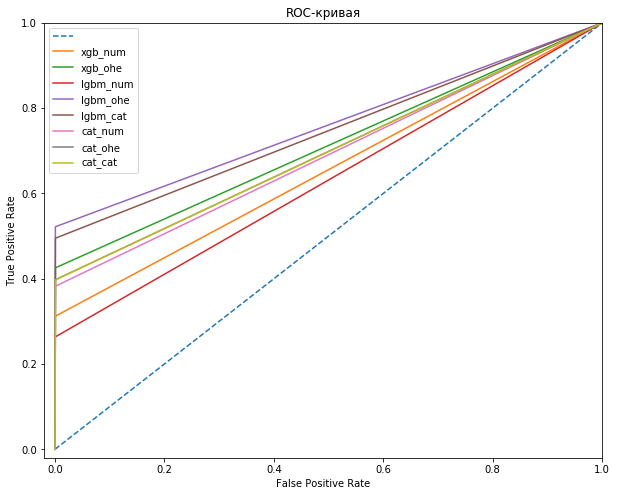

In [39]:

plt.figure( figsize=(10,8))

plt.plot([0, 1], [0, 1], linestyle='--')
for i in range(len(fpr_train_l)):
    plt.plot(fpr_train_l[i], tpr_train_l[i])


plt.legend(m)

plt.xlim([-0.02, 1.0])
plt.ylim([-0.02, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()

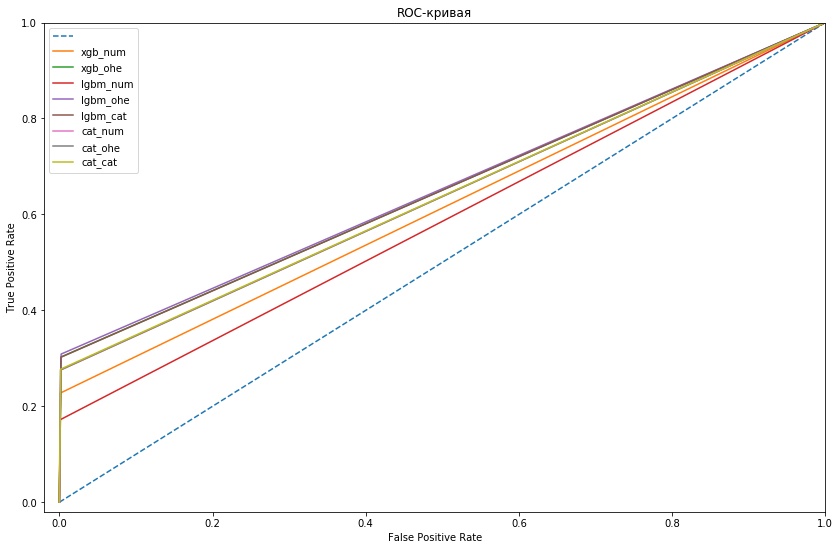

In [40]:

plt.figure( figsize=(14,9))

plt.plot([0, 1], [0, 1], linestyle='--')
for i in range(len(fpr_train_l)):
    plt.plot(fpr_test_l[i], tpr_test_l[i])

plt.legend(m)

plt.xlim([-0.02, 1.0])
plt.ylim([-0.02, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()

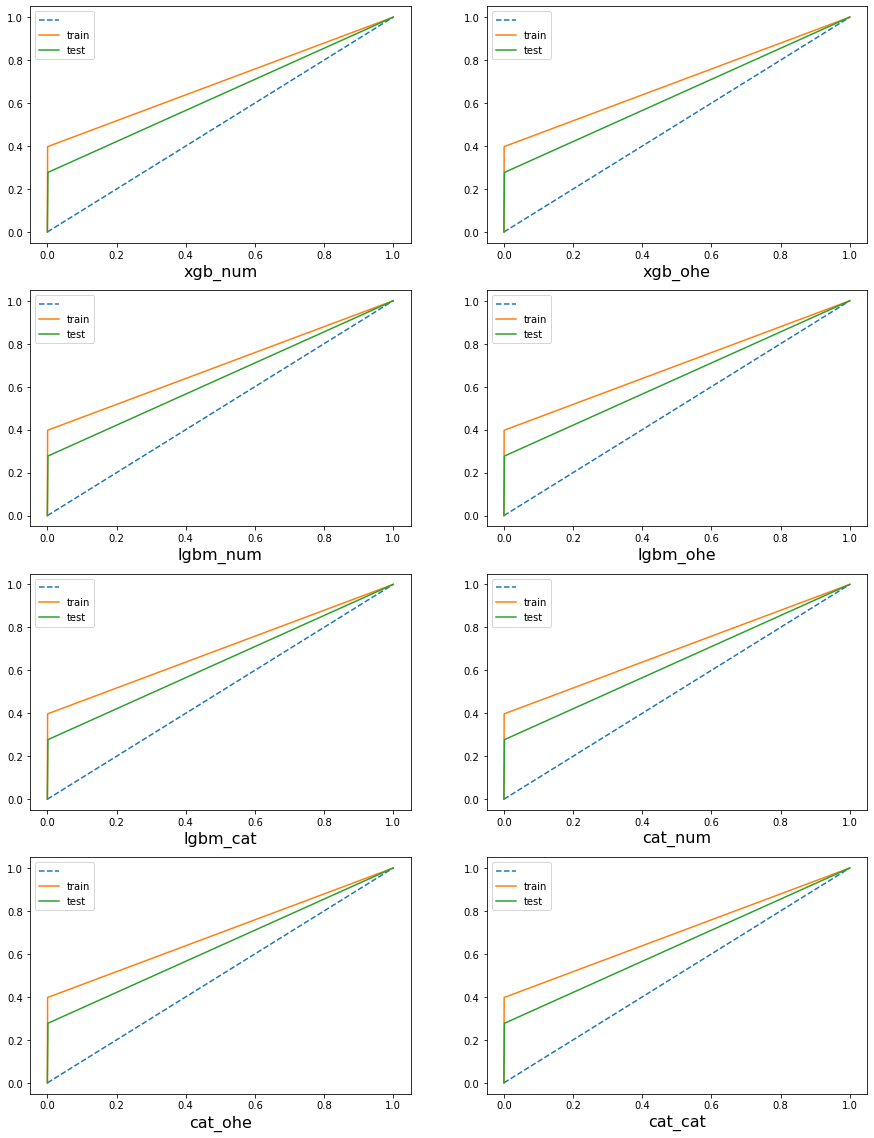

In [49]:
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
for num in range(len(fpr_train_l)):
    axes[num//2, num%2].plot([0, 1], [0, 1], linestyle='--')
    axes[num//2, num%2].plot(fpr_train_l[i], tpr_train_l[i])
    axes[num//2, num%2].plot(fpr_test_l[i], tpr_test_l[i])
    axes[num//2, num%2].set_xlabel(m[num+1], fontsize=16)
    axes[num//2, num%2].legend(['','train','test'])


## Задание на повторение:
Задание не обязательно к выполнению, но очень рекомендуется для понимания набора данных, этот набор данных будет использован и для следующего домашнего задания.

### Задание 1: Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.

In [30]:
train['TransactionDT'] = pd.to_datetime(train['TransactionDT'], unit ='s')
test['TransactionDT']  =  pd.to_datetime(test['TransactionDT'], unit ='s')

(array([719163., 719177., 719194., 719208., 719222., 719236., 719253.,
        719267., 719283.]),
 <a list of 9 Text xticklabel objects>)

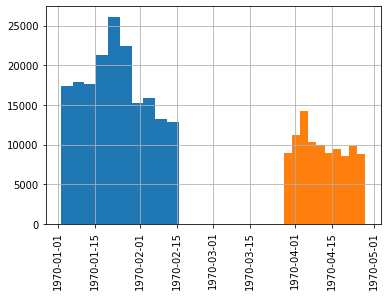

In [31]:
train['TransactionDT'].hist()
test['TransactionDT'].hist()
plt.xticks(rotation='vertical')

Данные тестовой и обучающей выборки в разных временных рамках.
Уместна рабзбиение по времени выборки для валидации. Мне кажется, и обычное случайное разбиение тоже ок.

### Задание 2: построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

In [50]:
train['TransactionH'] = pd.DatetimeIndex(train['TransactionDT']).hour
test['TransactionH']= pd.DatetimeIndex(test['TransactionDT']).hour

(array([-5.,  0.,  5., 10., 15., 20., 25.]),
 <a list of 7 Text xticklabel objects>)

<Figure size 720x576 with 0 Axes>

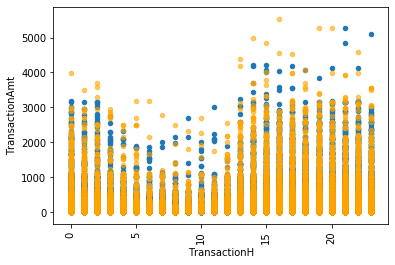

In [51]:
plt.figure( figsize=(10,8))
ax = train.plot.scatter(x ='TransactionH', y =  'TransactionAmt')
test.plot.scatter(x ='TransactionH', y =  'TransactionAmt', ax = ax, c='Orange', alpha = 0.6)
plt.xticks(rotation='vertical')


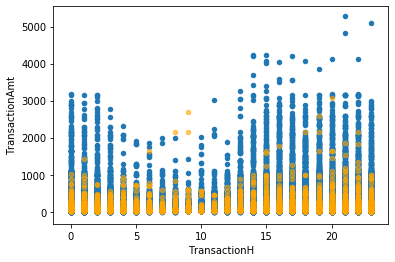

In [52]:
ax =train.loc[train['isFraud']==0].plot.scatter(x ='TransactionH', y =  'TransactionAmt')
train.loc[train['isFraud']==1].plot.scatter(x ='TransactionH', y =  'TransactionAmt', ax = ax, c='Orange', alpha = 0.6)

Видим, что прослеживается зависимость от часа совершения транзакции её суммы. Наблюдаем, что для обучения эта завсимость сохраняется. Для 1 значения целевой переменной этой зависимости нет.

### Задание 3: построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.

(array([9.6878e+04, 2.1100e+03, 4.9800e+02, 2.6600e+02, 1.3300e+02,
        8.0000e+01, 1.7000e+01, 1.1000e+01, 5.0000e+00, 3.0000e+00]),
 array([2.5100000e-01, 5.5454890e+02, 1.1088468e+03, 1.6631447e+03,
        2.2174426e+03, 2.7717405e+03, 3.3260384e+03, 3.8803363e+03,
        4.4346342e+03, 4.9889321e+03, 5.5432300e+03]),
 <a list of 10 Patch objects>)

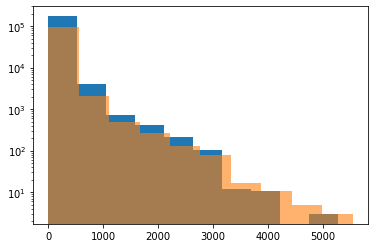

In [53]:
plt.hist(train['TransactionAmt'], log=True)
plt.hist(test['TransactionAmt'], log=True, alpha = 0.6)

Text(0.5, 1.0, 'Normal')

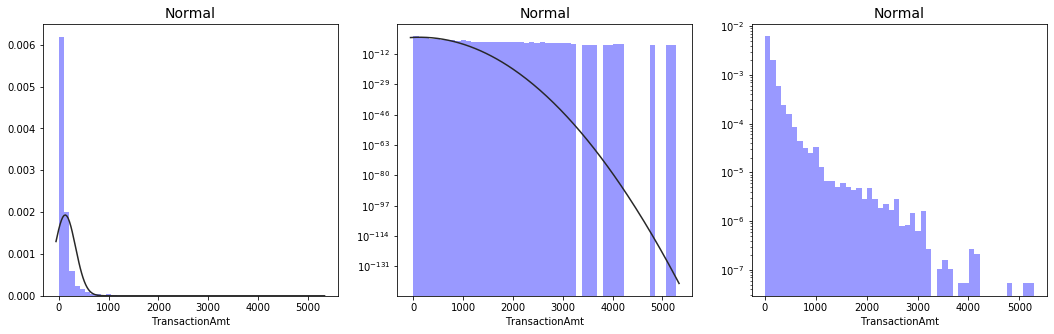

In [87]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.distplot(train['TransactionAmt'], kde=False,norm_hist=True,  color="blue", fit=st.norm,ax = axes[1])
axes[1].set_yscale('log')
axes[1].set_title("Normal", fontsize=14)

sns.distplot(train['TransactionAmt'], kde=False,norm_hist=True,  color="blue", fit=st.norm,ax = axes[0])
axes[0].set_title("Normal", fontsize=14)

sns.distplot(train['TransactionAmt'], kde=False,norm_hist=True,  color="blue", ax = axes[2])
axes[2].set_yscale('log')
axes[2].set_title("Normal", fontsize=14)

<span style='background :yellow' >
Почему так получается? на втором графике ???
</span>

Похоже на нормальное распределение, но с большим колличеством транзакций небольших сумм.

### Задание 4: построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.

In [16]:
feat_c = ['ProductCD', 'card4', 'card6']

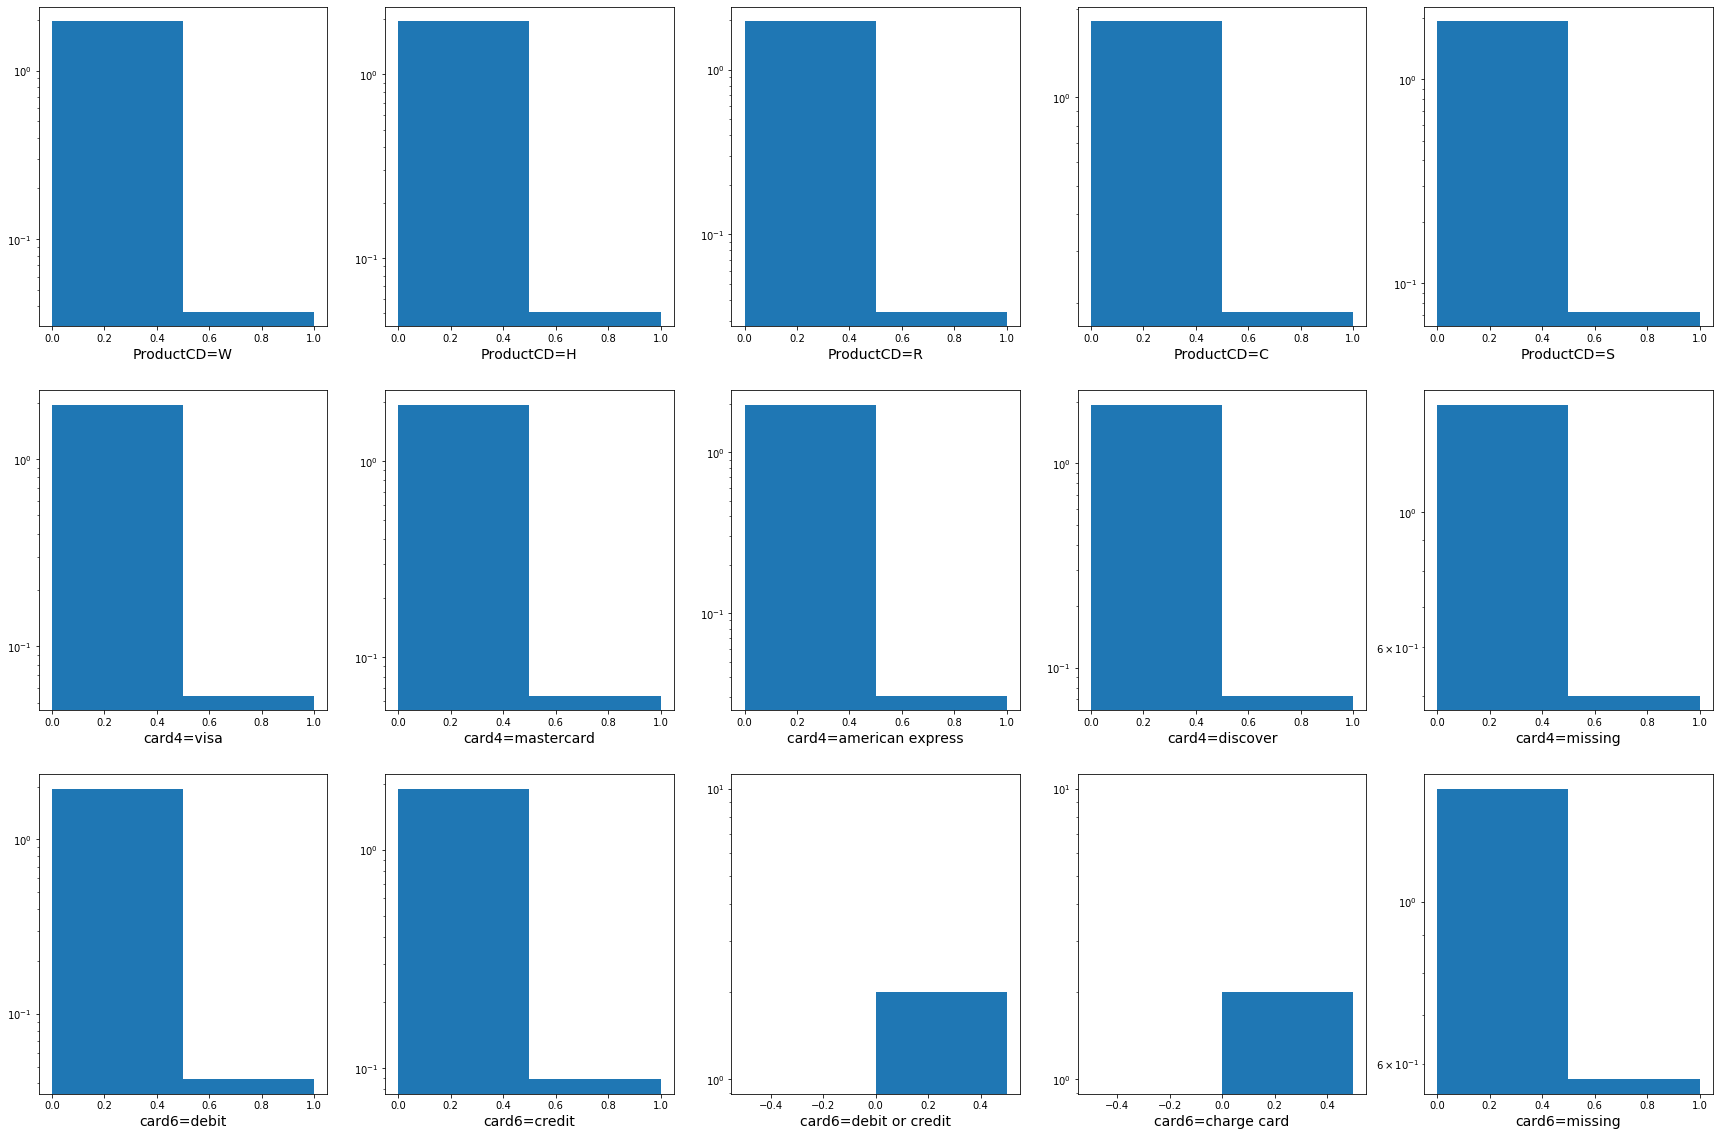

In [49]:
fig, axes = plt.subplots(3, 5, figsize=(30, 20))
num0=0
for feature_name in feat_c:
    for n, feature in enumerate(train[feature_name].fillna('missing').value_counts().reset_index()['index']):
        num=num0+n
        axes[num//5, num%5].hist(train.loc[train[feature_name] == feature, 'isFraud'], bins=2,density=True, log= True)
        axes[num//5, num%5].set_xlabel(feature_name+ '='+feature, fontsize=14)
        
        #axes[num//5, num%5].hist(test[feature], bins=2,alpha=0.55,density=True)       
    num0=num+1

Видим, что распределение везде похоже, кроме как в значениях card6 = debit or credit / change card. С этими значениями нужно быть на стороже.